In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Test Challenge - Definition


Here is the test challenge we discussed:

Goal: Determine whether there is an increase in activity level among users after installing Sweatcoin app.

The dataset includes daily step counts of the users (2 weeks before and after the install date):
- user_id - unique id of a user
- platform - device platform
- reg_date - registration date
- steps_date - date of steps
- steps - number of steps

Expected result: a Jupyter notebook with your analysis.

Looking forward to your insights. If you have any questions, feel free to reach out.

### How i'm going to solve it

Algorithm is as following:
- load data and preprocess
- explore data, fix dicovered nuances
- visualize data (distribution and trends per sampled users)
- choose the metric and statistical test
- conduct test, make conclusion 

### Load Data

In [7]:
df = pd.read_csv('data/data.csv')
print('\n', df.shape)
print('\n', df.nunique())
print()
print(df.info())
df.head()


 (81549, 6)

 Unnamed: 0    81549
user_id        3531
platform          2
reg_date         98
steps_date      112
steps         15707
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81549 entries, 0 to 81548
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  81549 non-null  int64 
 1   user_id     81549 non-null  int64 
 2   platform    81426 non-null  object
 3   reg_date    81549 non-null  object
 4   steps_date  81549 non-null  object
 5   steps       81549 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 3.7+ MB
None


,Unnamed: 0,user_id,platform,reg_date,steps_date,steps
0,0,41785284,IOS,2021-04-21,2021-04-13,458
1,1,41792465,IOS,2021-04-21,2021-04-13,5750
2,2,41494466,IOS,2021-03-28,2021-04-01,5635
3,3,41583452,IOS,2021-04-02,2021-04-01,1840
4,4,41637532,IOS,2021-04-07,2021-04-01,3127


### Preprocess Data

In [316]:
# drop columns
df = df.drop(columns=['Unnamed: 0'])
# convert string dates to dates
df['reg_date'] = pd.to_datetime(df['reg_date'])
df['steps_date'] = pd.to_datetime(df['steps_date'])
# difference between registration date and steps date 
df['days_diff'] = (df['steps_date'] - df['reg_date']).dt.days
df.head()

,user_id,platform,reg_date,steps_date,steps,days_diff
0,41785284,IOS,2021-04-21,2021-04-13,458,-8
1,41792465,IOS,2021-04-21,2021-04-13,5750,-8
2,41494466,IOS,2021-03-28,2021-04-01,5635,4
3,41583452,IOS,2021-04-02,2021-04-01,1840,-1
4,41637532,IOS,2021-04-07,2021-04-01,3127,-6


### Explore Data

In [317]:
# records for a random user
user_id_ = 41785284
print(f'For user {user_id_}:')
df.query(f'user_id in [{user_id_}]').sort_values(by='steps_date', ascending=True) #41785284

For user 41785284:


,user_id,platform,reg_date,steps_date,steps,days_diff
72358,41785284,IOS,2021-04-21,2021-04-07,1691,-14
64667,41785284,IOS,2021-04-21,2021-04-08,2400,-13
12711,41785284,IOS,2021-04-21,2021-04-09,1140,-12
47514,41785284,IOS,2021-04-21,2021-04-10,2370,-11
74539,41785284,IOS,2021-04-21,2021-04-11,594,-10
16349,41785284,IOS,2021-04-21,2021-04-12,3395,-9
0,41785284,IOS,2021-04-21,2021-04-13,458,-8
11988,41785284,IOS,2021-04-21,2021-04-14,1843,-7
78400,41785284,IOS,2021-04-21,2021-04-15,3277,-6
1065,41785284,IOS,2021-04-21,2021-04-16,4241,-5


For that user there are no records after refistrations. Let's explore deeply...

Let's calculate how many records per user we have before and after registration.
In parallel calculate some other metrics per user which will be useful for statistical analysis.

In [318]:
# Calculate per user metrics
df_agg = df.groupby('user_id').apply(calculate_metrics_per_user).reset_index()
df_agg.head()


/var/folders/cj/fzhjw_nx32q2sxr47_780dtw0000gn/T/ipykernel_14116/1687199103.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_agg = df.groupby('user_id').apply(calculate_metrics_per_user).reset_index()


,user_id,cnt_days_before,cnt_days_after,cnt_steps_before,cnt_steps_after
0,16661153,14,0,74119,0
1,19161801,14,14,42694,97810
2,19761882,14,2,0,3941
3,20395818,14,5,14363,2283
4,20702719,14,14,0,87465


Some users do not have 14 records before/after registrations. Also the steps count is 0 for some of them. Let's estimate how many?

In [319]:
# percentage of users with not complete records
pct_users = np.round(df_agg.query('cnt_days_before < 14 \
                                  or cnt_days_after < 14 \
                                  or cnt_steps_before==0 \
                                  or cnt_steps_after==0').shape[0] / df_agg['user_id'].nunique(), 2)
print(pct_users)

0.69


~69% of users whether do not have data for 14 days before or 14 after, or have steps count = 0

Let's leave for analysis users with at least 7 records before and 7 after.

0 for steps count is suspicious. Questions arise: can we trust this numbers? how steps counts where collected befare/after registration? I find it reasonable to filter out such users. But, let's leave them (just for curiosity) and do calculations for both cases.

In [321]:
# users with less than 7 records before/after
user_ids_to_remove = df_agg.query('cnt_days_before < 7 \
                                  or cnt_days_after < 7')['user_id'].unique()
# the same as above plus count of steps =0
user_ids_to_remove_2 = df_agg.query('cnt_days_before < 7 \
                                  or cnt_days_after < 7 \
                                  or cnt_steps_before == 0 \
                                  or cnt_steps_after == 0')['user_id'].unique()

print('Gonna remove N users: ', len(user_ids_to_remove))
#print('Gonna remove N users (2): ', len(user_ids_to_remove_2))
df_agg_processed = df_agg[~df_agg['user_id'].isin(user_ids_to_remove)]
print('N user before removal: ', df_agg.shape[0])
print('N user after removal: ', df_agg_processed.shape[0])
df_agg_processed.head()


Gonna remove N users:  1100
N user before removal:  3531
N user after removal:  2431


,user_id,cnt_days_before,cnt_days_after,cnt_steps_before,cnt_steps_after
1,19161801,14,14,42694,97810
4,20702719,14,14,0,87465
5,24770769,14,14,0,65148
7,31877017,14,14,0,58783
8,39957739,14,12,12187,12792


### Calculate Metrics

As a metric let's choose Average Steps per User per Day. We're gonna analyse it before and after registration. i.e.differences in Average steps per day per User.

In [323]:
df_agg_processed = df_agg_processed.copy()
df_agg_processed.loc[:, 'avg_steps_per_day_before'] = df_agg_processed['cnt_steps_before'] / df_agg_processed['cnt_days_before']
df_agg_processed.loc[:, 'avg_steps_per_day_after'] = df_agg_processed['cnt_steps_after'] / df_agg_processed['cnt_days_after']
print(df_agg_processed.shape)
df_agg_processed.head(5)

(2431, 7)


,user_id,cnt_days_before,cnt_days_after,cnt_steps_before,cnt_steps_after,avg_steps_per_day_before,avg_steps_per_day_after
1,19161801,14,14,42694,97810,3049.571429,6986.428571
4,20702719,14,14,0,87465,0.000000,6247.500000
5,24770769,14,14,0,65148,0.000000,4653.428571
7,31877017,14,14,0,58783,0.000000,4198.785714
8,39957739,14,12,12187,12792,870.500000,1066.000000


### Visualize Distributions

/var/folders/cj/fzhjw_nx32q2sxr47_780dtw0000gn/T/ipykernel_14116/989738900.py:68: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend(handles, labels=['Before Registration', 'After Registration'], loc='center', bbox_to_anchor=(0.5, -0.05), ncol=2, title='Registration Status')


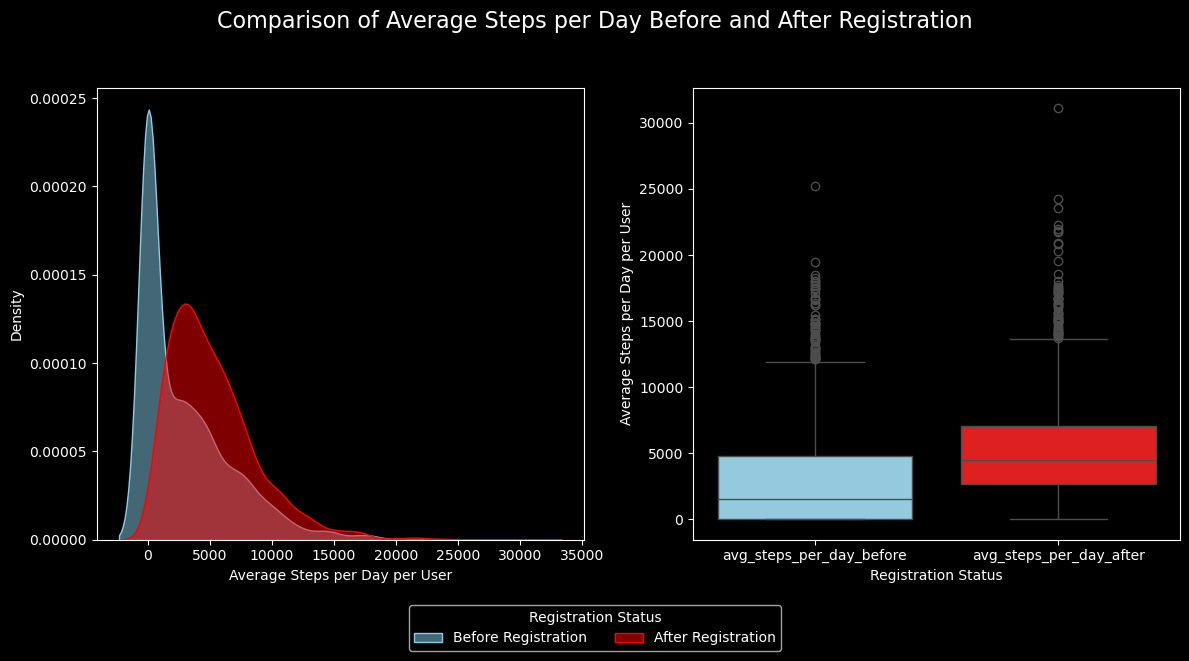

In [326]:
# visualize distributions for the case when users with 0 steps count remained
vis_distributions(df=df_agg_processed[['avg_steps_per_day_before', 'avg_steps_per_day_after']])

Looks beautiful, classic shapes... Effect is visible. We have outliers. 

Important: visual differences in location of curves in our case can be sometimes misleading, since we are going analize differences between metrics (about this - below).

Let's plot the same for the case when suspecious users with 0 steps are removed.

In [249]:
# some numbers to better understand the effect of removal 
print('Count users with 0 steps before registration: ', df_agg_processed.query('cnt_steps_before == 0').shape[0])
print('Count users with 0 steps after registration: ', df_agg_processed.query('cnt_steps_after == 0').shape[0])
user_ids_to_remove_2 = df_agg_processed.query('cnt_steps_before == 0 or cnt_steps_after == 0')['user_id'].unique()
df_agg_processed_2 = df_agg_processed[~df_agg_processed['user_id'].isin(user_ids_to_remove_2)]
print('Count user before removal: ', df_agg_processed.shape[0])
print('Count user after removal: ', df_agg_processed_2.shape[0])

Count users with 0 steps before registration:  985
Count users with 0 steps after registration:  6
Count user before removal:  2431
Count user after removal:  1446


The majority of users for whome we have more than 7 records before and after registration with 0s for steps count have these 0s BEFORE registration, not after. It's important to clarify this.

/var/folders/cj/fzhjw_nx32q2sxr47_780dtw0000gn/T/ipykernel_14116/592182478.py:34: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend(handles, labels=['Before Registration', 'After Registration'], loc='center', bbox_to_anchor=(0.5, -0.05), ncol=2, title='Registration Status')


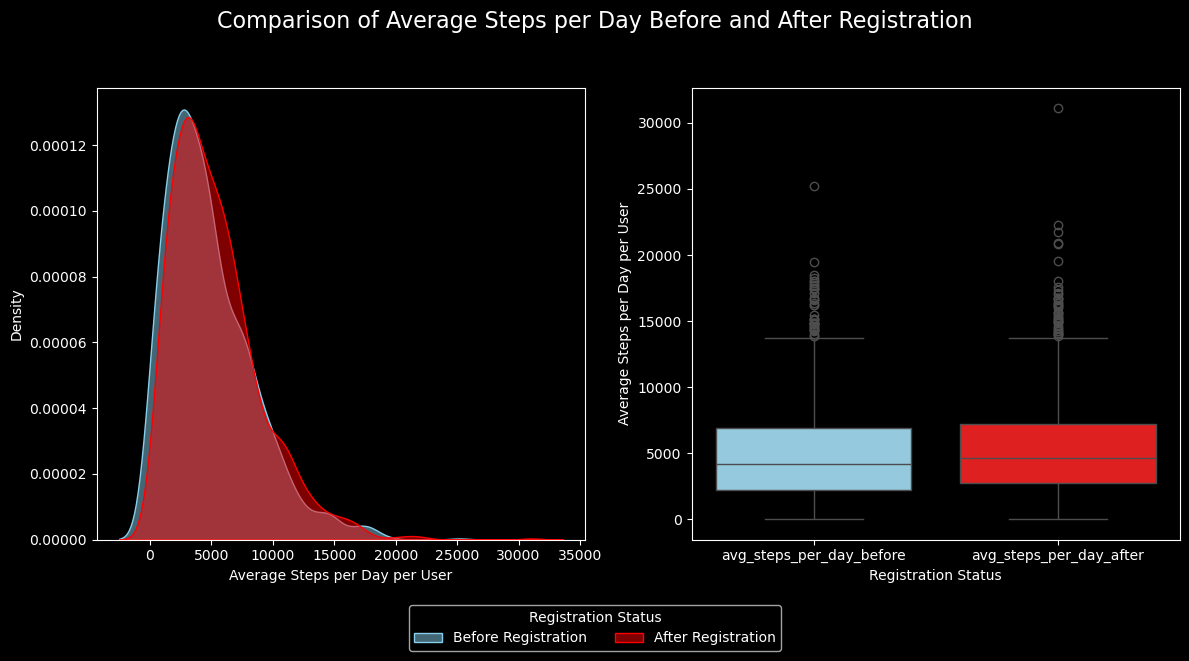

In [245]:
# visualize distributions for the case when users with 0 steps count removed
vis_distributions(df=df_agg_processed_2[['avg_steps_per_day_before', 'avg_steps_per_day_after']])

Not so impressive.. Difference is not so distinguishable visually. But again, important to remember: visual differences in location of curves in our case can be sometimes misleading, since we are going analize differences between metrics (about this - below).


### Visualize trends for the sample of users

To get better understanding of the presence/abscence of the possible effect let's visualize steps trends for some random users.

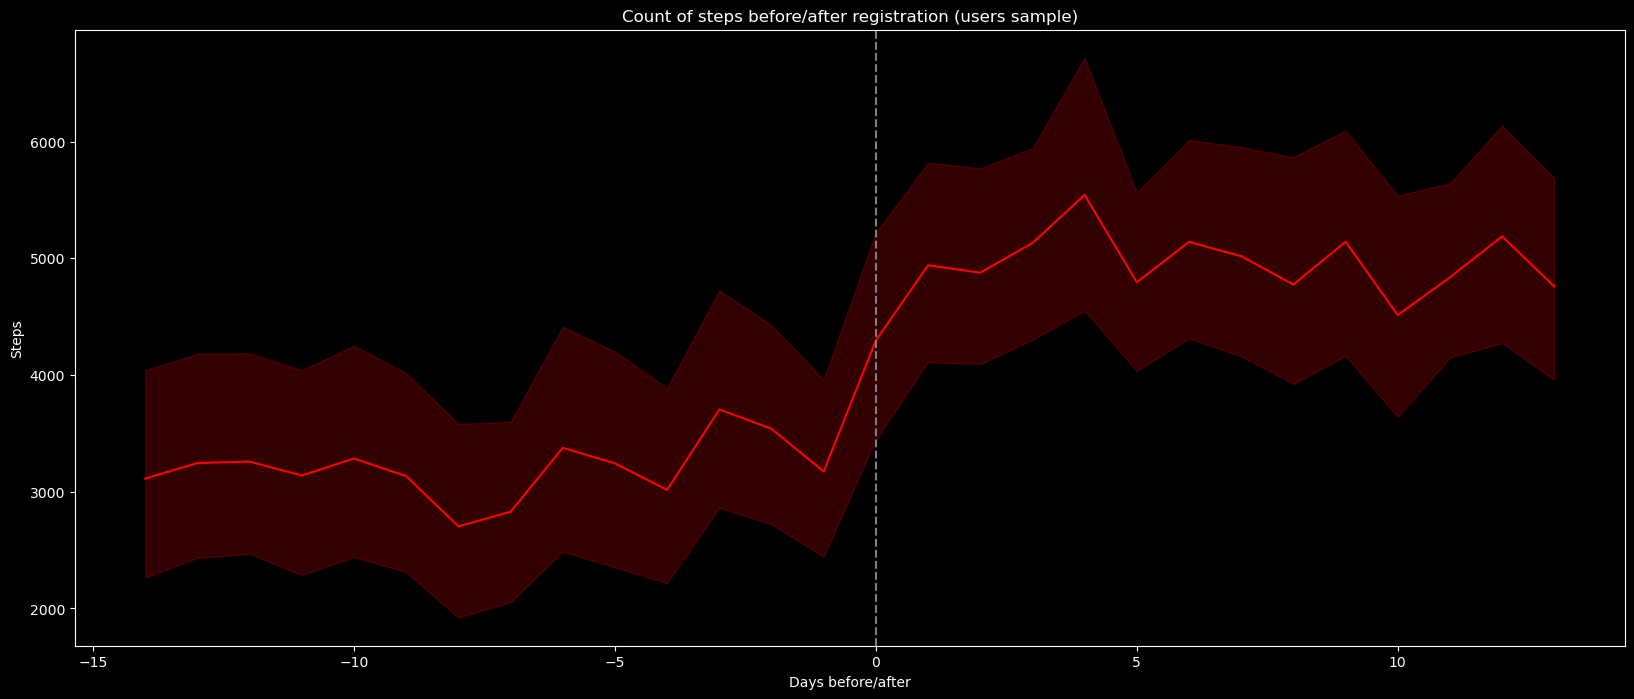

In [346]:
# step trends for sampled users with count of records before/after registration >= 7 
vis_trends(df=df[~df['user_id'].isin(user_ids_to_remove)])

It's evident that there is an effect of physical activity increase after app installation.

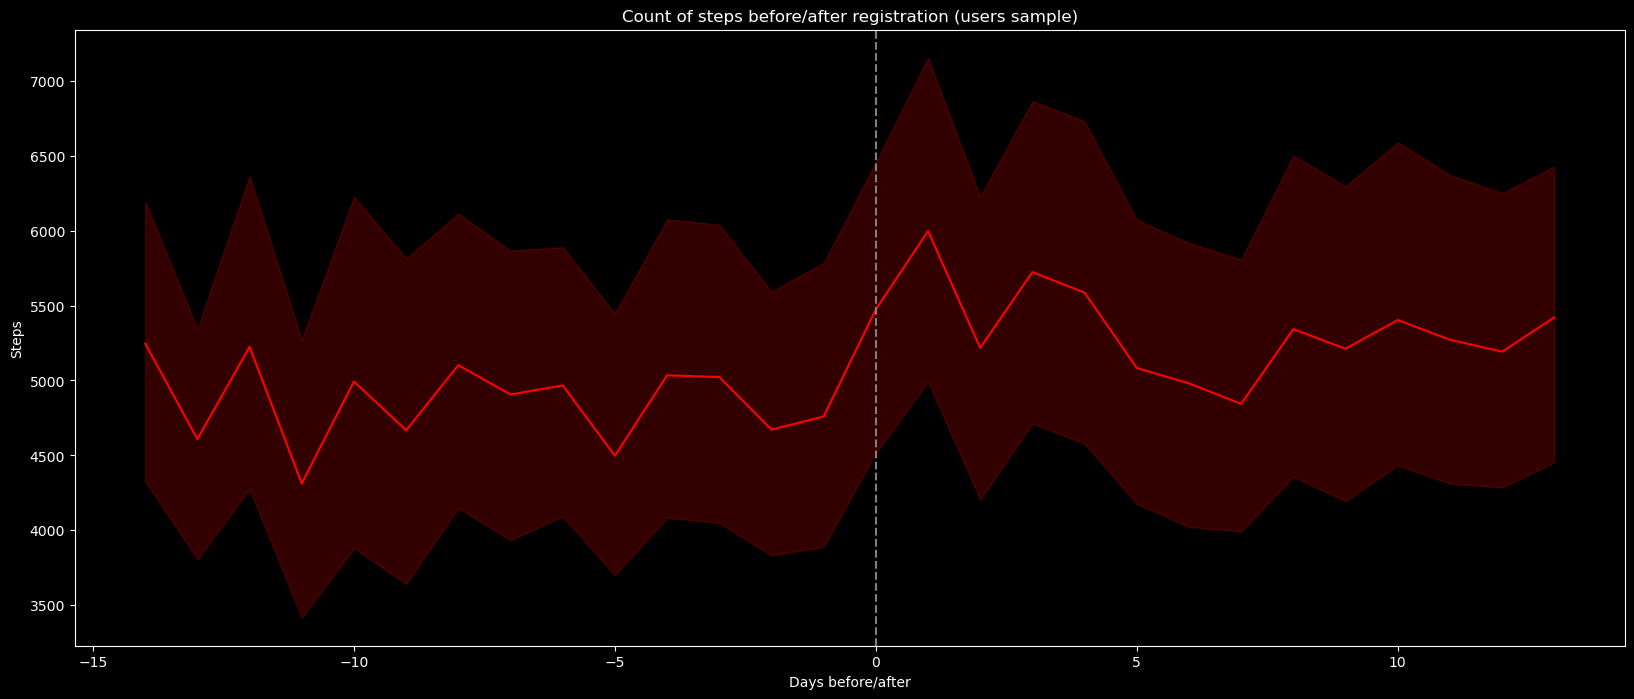

In [348]:
# step trends for sampled users with count of records before/after registration >=7 
#   AND count of steps before or after != 0
vis_trends(df=df[~df['user_id'].isin(user_ids_to_remove_2)])

Here the effect is less remarkable.

### Statistical Test

Our metric - Average Number of Steps per Day per User. 

We have a paired case when dataset contains metrics per user before and after speific point in time - registration in the app. 

For that case we can use paired t-test or non-parametric Wilcoxon signed-rank test. 

Our hypothesis:

- H0: the mean of difference between paired observation is 0 (no statistically significant difference before/after)
- Ha: the mean of difference between paired observation != 0 (there is statistically significant effect in either direction)

Let's check the distribution of differences of our metric per user to take decision about the test.

Shapiro-Wilk Test Statistic: 0.9188117648553528, p-value: 2.7190208849967443e-34


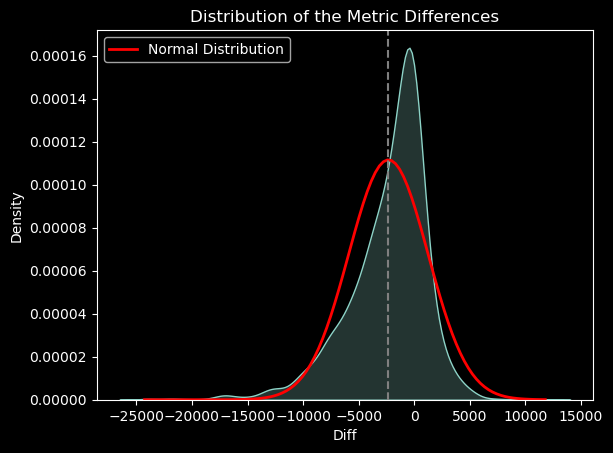

In [340]:
# calculate differences between pairs of the metric per user
diff = df_agg_processed['avg_steps_per_day_before'] - df_agg_processed['avg_steps_per_day_after']
# remove outliers
#diff = winsorize(df_agg_processed['avg_steps_per_day_before'], limits=[0.05, 0.05]) - winsorize(df_agg_processed['avg_steps_per_day_after'], limits=[0.05, 0.05])

# check normality of the diff
shapiro_test = stats.shapiro(diff)
print(f'Shapiro-Wilk Test Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}')

# check normality visually (AK: add Q-Q plot)
mu, std = np.mean(diff), np.std(diff)
xmin, xmax = min(diff), max(diff)
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
sns.kdeplot(x=diff, fill='blue')
sns.lineplot(x=x, y=p, linewidth=2, label='Normal Distribution', color='red')
plt.axvline(x=np.mean(diff),ls='--', color='grey')
plt.title('Distribution of the Metric Differences')
plt.xlabel('Diff')
plt.show()

Shapiro test tells us that our data is not normally distributed. But we have large enough sample. We can use both tests (parametric and not). I'll do calculation for both (paired t-test and wilcoxon). Our target: to understand how far away from 0 the mean of paired differences is located.

In [337]:
# Run ttest for the case when users with 0 steps not removed
run_stat_test(var1=df_agg_processed['avg_steps_per_day_before'], 
          var2=df_agg_processed['avg_steps_per_day_after'], 
          remove_outliers=False, # doesn't influence the result
          verbose=False)


Result (t-test):
T-test statistic: -32.11924207058643, p-value: 5.685796183000483e-189
There is a significant difference in physical activity before and after registration.

Result (wilcoxon):
Wilcoxon test statistic: 451297.0, p-value: 4.356729946682424e-192
There is a significant difference in physical activity before and after registration.


In [364]:
# Run ttest for the case when users with 0 steps are REMOVED
run_stat_test(var1=df_agg_processed_2['avg_steps_per_day_before'], 
          var2=df_agg_processed_2['avg_steps_per_day_after'], 
          remove_outliers=False, # doesn't influence the result
          verbose=False)


Result (t-test):
T-test statistic: -8.592688945216542, p-value: 2.1683379236672322e-17
There is a significant difference in physical activity before and after registration.

Result (wilcoxon):
Wilcoxon test statistic: 388106.0, p-value: 1.9029621387358576e-17
There is a significant difference in physical activity before and after registration.


### Conclusion

The results of both statistical tests (the paired t-test and the Wilcoxon signed-rank test) indicate a statistically significant difference in physical activity levels before and after registration. Given these extremely low p-values, we reject the null hypothesis and conclude that registration is associated with a meaningful change in physical activity.

Can we generalize it to the whole population?

It depends on:
- how the sample was formed? is it representative of the whole population? Is it randomized and stratified?
- are all observation independant or represent a specific subset of user? Here, for example, referential programs discussed on the call come into the game, and can introduce a bias.
- the sample size (which, in our case, is ok) tells us whether, under the above conditions, we can consider the sample mean a reliable estimate of the population mean.


## Ad-Hoc (not relevant to the task)

### t-test manually

mean_diff: 512.780106068436
std_diff: 2269.27027138514
n: 2431
t_stat: 11.141339892278777
Paired t-test results:
Mean difference: 512.780106068436
Standard deviation of differences: 2269.27027138514
Number of observations: 2431
T-statistic: 11.141339892278777
P-value: 3.748351998126867e-28
Reject the null hypothesis: There is a statistically significant difference.


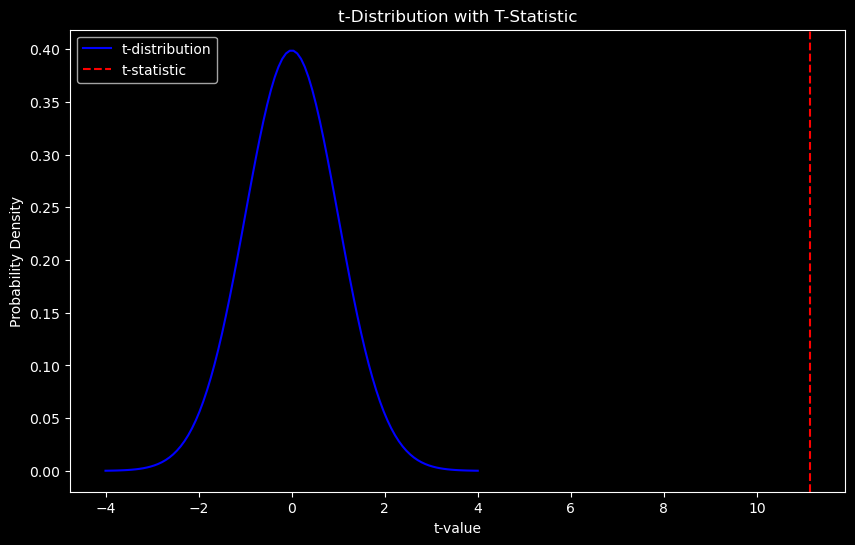

In [357]:


# calculate the differences
diff = df_agg_processed_2['avg_steps_per_day_after'] - df_agg_processed_2['avg_steps_per_day_before']

# mean of differences
mean_diff = diff.mean()
print('mean_diff:', mean_diff)

# standard deviation of differences
std_diff = diff.std(ddof=1)
print('std_diff:', std_diff)

# number of observations
n = len(df)
print('n:', n)

# calculate the t-statistic
t_stat = mean_diff / (std_diff / np.sqrt(n))
print('t_stat:', t_stat)

# calculate the p-value
# Degrees of freedom is n - 1 for a paired t-test
p_value = stats.t.sf(np.abs(t_stat), df=n-1) * 2  # two-sided test

# results
print("Paired t-test results:")
print(f"Mean difference: {mean_diff}")
print(f"Standard deviation of differences: {std_diff}")
print(f"Number of observations: {n}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# conclusion
alpha = 0.05  # Common significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a statistically significant difference.")
else:
    print("Fail to reject the null hypothesis: No statistically significant difference.")

# Visualization of the t-distribution
degrees_of_freedom = n - 1
x = np.linspace(-4, 4, 100)  # Range of x values for the t-distribution
y = stats.t.pdf(x, df=degrees_of_freedom)  # Probability density function of the t-distribution

plt.figure(figsize=(10, 6))
sns.lineplot(x=x, y=y, color='blue', label='t-distribution')
plt.axvline(t_stat, color='red', linestyle='--', label='t-statistic')
plt.title('t-Distribution with T-Statistic')
plt.xlabel('t-value')
plt.ylabel('Probability Density')
plt.legend()

# Optionally, shade the critical regions
#critical_value = stats.t.ppf(1 - alpha / 2, df=degrees_of_freedom)
#plt.fill_between(x, y, where=(x < -critical_value) | (x > critical_value), color='lightgray', alpha=0.5, label='Critical Region')

plt.show()

### Bootstrap diff for confindence interval

Observed mean of paired differences: 512.780106068436
95% Confidence Interval: [399.0602747325193, 629.5200345905247]
The confidence interval does not include zero, suggesting a significant difference.


<Axes: ylabel='Density'>

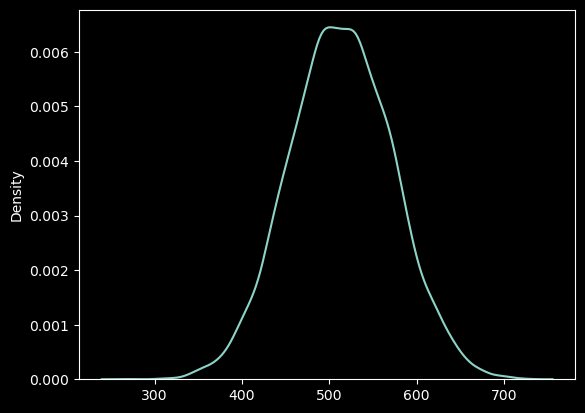

In [360]:
# Calculate paired differences
diffs = df_agg_processed_2['avg_steps_per_day_after'] - df_agg_processed_2['avg_steps_per_day_before']

# Calculate the observed mean of paired differences
observed_diff_mean = diffs.mean()

# Define a function for bootstrap sampling of the paired differences
def bootstrap_paired_diff(diffs, n_bootstrap=1000):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        # Resample the differences with replacement
        sample_diffs = np.random.choice(diffs, size=len(diffs), replace=True)
        # Calculate the mean of this resampled differences
        bootstrapped_means.append(sample_diffs.mean())
    return np.array(bootstrapped_means)

# Generate bootstrap samples
bootstrap_means = bootstrap_paired_diff(diffs, n_bootstrap=10000)

# Calculate the 95% confidence interval
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

print(f"Observed mean of paired differences: {observed_diff_mean}")
print(f"95% Confidence Interval: [{lower_bound}, {upper_bound}]")

# Interpretation of results
if lower_bound > 0 or upper_bound < 0:
    print("The confidence interval does not include zero, suggesting a significant difference.")
else:
    print("The confidence interval includes zero, suggesting no significant difference.")


# visualize
sns.kdeplot(bootstrap_means)